In [1]:
# !pip install transformers sentence-transformers openai
!pip install -U datasets

In [2]:
# Load data from huggingface
from datasets import load_dataset
dataset = load_dataset("maartengr/arxiv_nlp")["train"]

# Extract metadata
abstracts = dataset["Abstracts"]
titles = dataset["Titles"] 

In [3]:
len(abstracts)

44949

In [4]:
import pprint
pprint.pprint(abstracts)

Column(['  In this paper Arabic was investigated from the speech recognition problem\npoint of view. We propose a novel approach to build an Arabic Automated Speech\nRecognition System (ASR). This system is based on the open source CMU Sphinx-4,\nfrom the Carnegie Mellon University. CMU Sphinx is a large-vocabulary;\nspeaker-independent, continuous speech recognition system based on discrete\nHidden Markov Models (HMMs). We build a model using utilities from the\nOpenSource CMU Sphinx. We will demonstrate the possible adaptability of this\nsystem to Arabic voice recognition.\n', '  In this paper we present the creation of an Arabic version of Automated\nSpeech Recognition System (ASR). This system is based on the open source\nSphinx-4, from the Carnegie Mellon University. Which is a speech recognition\nsystem based on discrete hidden Markov models (HMMs). We investigate the\nchanges that must be made to the model to adapt Arabic voice recognition.\n  Keywords: Speech recognition, Acous

In [5]:
from sentence_transformers import SentenceTransformer

# Create an embedding for each abstract
embedding_model = SentenceTransformer('thenlper/gte-small')
embeddings = embedding_model.encode(abstracts, show_progress_bar=True)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1405 [00:00<?, ?it/s]

In [9]:
# Check the dimensions of the resulting embeddings
embeddings.shape

(44949, 384)

In [10]:
!pip install umap-learn


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [12]:
from umap import UMAP

umap_model = UMAP(
    n_components=5,
    min_dist=0.0,
    metric="cosine",
    random_state=42
)

reduced_embeddings = umap_model.fit_transform(embeddings)
print(reduced_embeddings.shape)


/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(44949, 5)


In [14]:
from hdbscan import HDBSCAN

# We fit the model and extract the clusters
hdbscan_model = HDBSCAN(
    min_cluster_size=50, metric='euclidean', cluster_selection_method='eom'
).fit(reduced_embeddings)
clusters = hdbscan_model.labels_

# How many clusters did we generate?
len(set(clusters))

/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


157

In [18]:
import numpy as np

# Print first three documents in cluster 0
cluster = 0
for index in np.where(clusters==cluster)[0][:2]:
    print(abstracts[index][:300] + "... \n")



  This works aims to design a statistical machine translation from English text
to American Sign Language (ASL). The system is based on Moses tool with some
modifications and the results are synthesized through a 3D avatar for
interpretation. First, we translate the input text to gloss, a written fo... 

  Researches on signed languages still strongly dissociate lin- guistic issues
related on phonological and phonetic aspects, and gesture studies for
recognition and synthesis purposes. This paper focuses on the imbrication of
motion and meaning for the analysis, synthesis and evaluation of sign lang... 



In [16]:
import pandas as pd

# Reduce 384-dimensional embeddings to 2 dimensions for easier visualization
reduced_embeddings = UMAP(
    n_components=2, min_dist=0.0, metric='cosine', random_state=42
).fit_transform(embeddings)

# Create dataframe
df = pd.DataFrame(reduced_embeddings, columns=["x", "y"])
df["title"] = titles
df["cluster"] = [str(c) for c in clusters]

# Select outliers and non-outliers (clusters)
clusters_df = df.loc[df.cluster != "-1", :]
outliers_df = df.loc[df.cluster == "-1", :]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(-9.598746156692505,
 11.940637445449829,
 -1.4646184563636782,
 15.40914489030838)

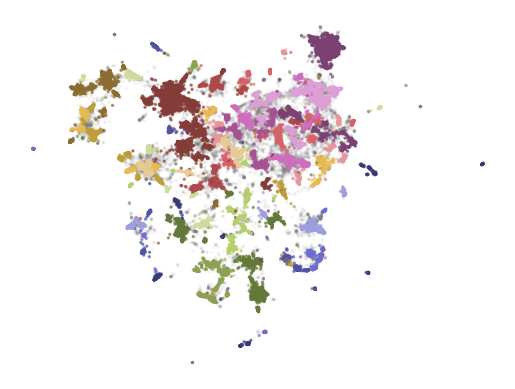

In [17]:
import matplotlib.pyplot as plt

# Plot outliers and non-outliers seperately
plt.scatter(outliers_df.x, outliers_df.y, alpha=0.05, s=2, c="grey")
plt.scatter(
    clusters_df.x, clusters_df.y, c=clusters_df.cluster.astype(int),
    alpha=0.6, s=2, cmap='tab20b'
)
plt.axis('off')
# plt.savefig("matplotlib.png", dpi=300)  # Uncomment to save the graph as a .png